# Using SAS DLPy to Create a Deep Learning Model to Classify age from faces 
The following example uses SAS DLPy to create a CNN(convolutional) image classification model. The model task is to analyze faces captured by a computer webcam and determine age


## Table of Contents

   * Setup Libraries and Launch CAS
   * Load and Explore the Training Data
   * Prepare the Data for Modeling
   * Specify the Model Architecture, Configure Model Parameters, Import Pre-Trained Weights
   * Fit the Image Detection and Classification Model
   * Score the Test Data to Predict Image Classes
   * Visualize Model Leanring
   * Save Model as ASTORE for Deployment   
   

## SWAT Setup 

In order for python to communicate with Viya and issue CAS actions the SWAT module is needed. https://github.com/sassoftware/python-swat  (Scripting Wrapper for Analytics Transfer)  

In [1]:
import sys
sys.path.append("/opt/sasinside/anaconda3/lib/python3.6/site-packages")
import  swat  # Sets up session with Viya and controls CAS actions
from swat import *
swat.__version__

'1.5.1'

## Setup Standard Python Libraries

In [2]:
import matplotlib.pyplot as plt  # graphing 
%matplotlib inline
import numpy as np    # multidementions array manipulator 
import pandas as pd   # data analysis
import random

## Import Deep Learning Module

DLPy is a high-level package for the Python APIs created for the
SAS Viya 3.3 (and newer) Deep Learning and Image action sets. DLPy
provides a convenient way to perform deep learning image processing.
https://gitlab.sas.com/bsloane/dlpy

In [3]:
import dlpy
from dlpy import Model, Sequential
from dlpy.model import *
#from dlpy.layers import *
from dlpy.applications import *
from dlpy.utils import *
from dlpy.images import ImageTable
from dlpy.splitting import two_way_split
from dlpy.blocks import *
dlpy.__version__ 


'1.0.1'

After importing the required libraries and utilities, connect to SAS CAS. You will need to know the name of your CAS server and port ID, as well as your userID and password.

In [4]:
s = swat.CAS('iotland',"5570", "sasdemo","sasdemo") 
serverstatus = s.serverStatus()
#serverstatus

NOTE: Grid node action status report: 1 nodes, 8 total actions executed.


## Load Deep Learning Action Sets

While CAS comes with a few pre-loaded action sets, you will likely want to load action sets with other capabilities such as percentiles, Data step, SQL, or even machine learning. Most action sets will require a license to run them, so you’ll have to take care of those issues before you can load them.

In [5]:
s.loadactionset('image')
s.loadactionset('deepLearn')

NOTE: Added action set 'image'.
NOTE: Added action set 'deepLearn'.


[actionset]

 'deepLearn'

+ Elapsed: 0.00401s, sys: 0.00399s, mem: 0.23mb

#### There are 2 inputs needed to train a model.  
    1. Images files 
    2. Pre-trained weights file
#### We will also need a caslib location on the CAS server to store working files and  results.  This path is system dependant so ask your system admin for the correct location.  

In [6]:
modelPath='/data/'
s.table.addcaslib(activeonadd=True,datasource={'srctype':'path'},name='Happy',path=modelPath,subdirectories=True)
s.setsessopt(caslib='Happy')  #  Set default active caslib


NOTE: 'Happy' is now the active caslib.
NOTE: Cloud Analytic Services added the caslib 'Happy'.
NOTE: 'Happy' is now the active caslib.


+ Elapsed: 0.000387s, user: 0.000371s, mem: 0.243mb

In [7]:
s.table.caslibInfo() 

,Name,Type,Description,Path,Definition,Subdirs,Local,Active,Personal,Hidden,Transient
0,CASUSER(sasdemo),PATH,Personal File System Caslib,/home/sasdemo/casuser/,,1.0,0.0,0.0,1.0,0.0,1.0
1,Public,PATH,"Shared and writeable caslib, accessible to all...",/opt/sas/viya/config/data/cas/default/public/,,0.0,0.0,0.0,0.0,0.0,0.0
2,Happy,PATH,,/data/,,1.0,1.0,1.0,0.0,0.0,0.0


In [8]:
s.tableinfo()

NOTE: No tables are available in caslib Happy of Cloud Analytic Services.


+ Elapsed: 0.000701s, user: 0.000337s, sys: 0.000326s, mem: 0.292mb

## Load and Explore the Training Data

Now use load_files from DLPy ImageTable to create a CAS table named my_images. Labels are inherited from subdirectory names when you use load_files.

In [9]:
modelPath='/data/'
my_images = ImageTable.load_files(s, path=modelPath+'ageimages',casout=dict(name='my_images',caslib='Happy'))

In [10]:
s.tableinfo()

,Name,Rows,Columns,IndexedColumns,Encoding,CreateTimeFormatted,ModTimeFormatted,AccessTimeFormatted,JavaCharSet,CreateTime,...,Global,Repeated,View,SourceName,SourceCaslib,Compressed,Creator,Modifier,SourceModTimeFormatted,SourceModTime
0,MY_IMAGES,23741,4,0,utf-8,2019-07-01T09:03:33-04:00,2019-07-01T09:03:33-04:00,2019-07-01T09:03:33-04:00,UTF8,1.877605e+09,...,0,0,0,,,0,sasdemo,,,NaN


#### Use show() to display a table of 16 randomly selected images, in two rows of 4 columns.

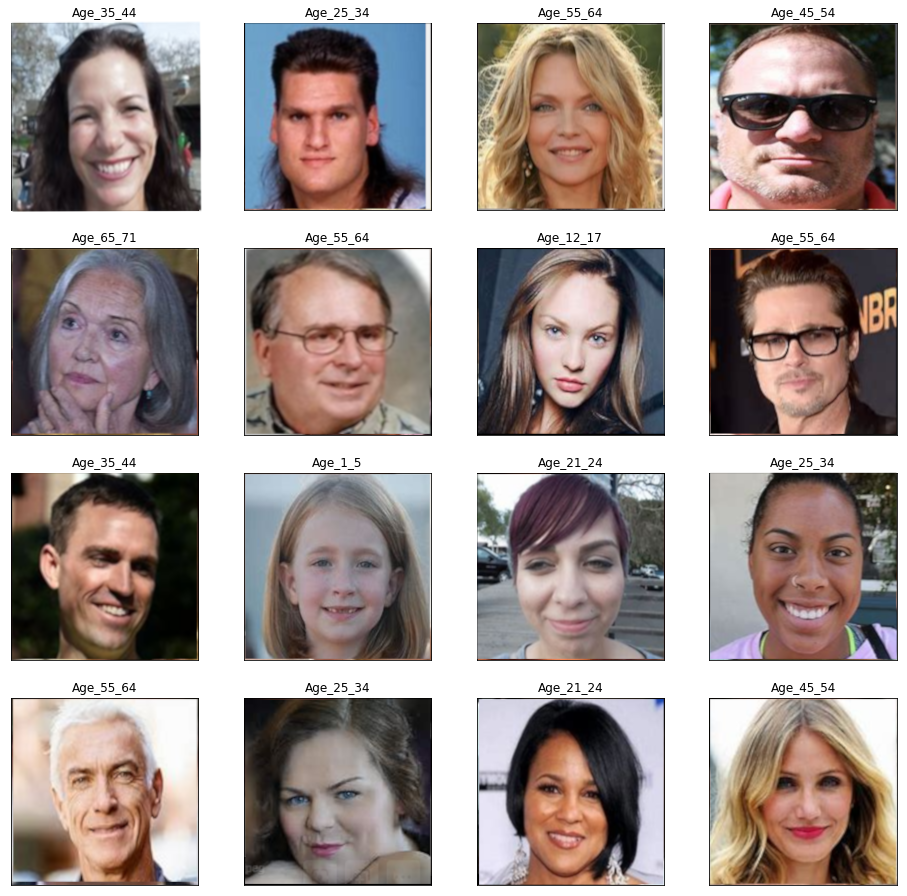

In [11]:
my_images.show(nimages=16, ncol=4, randomize=True)

In [12]:
my_images.head()

,_image_,_label_,_filename_0,_id_
0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,Age_45_54,Age_45_5419151.jpg,1
1,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,Age_45_54,Age_45_5417345.jpg,2
2,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,Age_45_54,Age_45_5418662.jpg,3
3,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,Age_45_54,Age_45_5417996.jpg,4
4,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,Age_45_54,Age_45_5418518.jpg,5


##  Frequency 
Use the label_freq() function to verify the amount of entries from each class in the table. 

In [13]:
my_images.label_freq

,Level,Frequency
Age_1_5,1,2363
Age_12_17,2,950
Age_18_20,3,644
Age_21_24,4,2026
Age_25_34,5,7324
Age_35_44,6,3428
Age_45_54,7,2409
Age_55_64,8,1686
Age_6_11,9,920
Age_65_71,10,766


In [14]:
my_images.image_summary

jpg                 23741
minWidth              416
maxWidth              416
minHeight             416
maxHeight             416
meanWidth             416
meanHeight            416
mean1stChannel    99.6222
min1stChannel           0
max1stChannel         255
mean2ndChannel    116.389
min2ndChannel           0
max2ndChannel         255
mean3rdChannel        152
min3rdChannel           0
max3rdChannel         255
dtype: object

## Shuffle

It is always a good staticical practice to shuffle the dataset before training.  

In [15]:
# Shuffle Images
my_images.shuffle(casout=dict(name='my_images', replace=True));

## Resize 

In our case, we need to increase the size of the images to 224. 

In [16]:
my_images.resize(width=224, height=224)

## Split Images into Training and Testing Datasets

Now use the two_way_split() function to divide the model data into train and test partitions. Use random seed 215, and partition the data so that 80% of observations are allocated to the train partition tr_img and 20% of observations are allocated to the test partition te_img.

In [17]:
tr_img, te_img = two_way_split(my_images, test_rate=20, stratify_by='_label_', seed = 215)

In [18]:
my_images.summarizeimages()

NOTE: Table MY_IMAGES contains compressed images.
NOTE: 23741 out of 23741 images were scanned and results were saved to the summary table.


,Column,jpg,minWidth,maxWidth,minHeight,maxHeight,meanWidth,meanHeight,mean1stChannel,min1stChannel,max1stChannel,mean2ndChannel,min2ndChannel,max2ndChannel,mean3rdChannel,min3rdChannel,max3rdChannel
0,_image_,23741.0,224.0,224.0,224.0,224.0,224.0,224.0,99.531349,0.0,255.0,116.297242,0.0,255.0,151.898408,0.0,255.0


In [19]:
tr_img.label_freq

,Level,Frequency
Age_1_5,1,1890
Age_12_17,2,760
Age_18_20,3,515
Age_21_24,4,1621
Age_25_34,5,5859
Age_35_44,6,2742
Age_45_54,7,1927
Age_55_64,8,1349
Age_6_11,9,736
Age_65_71,10,613


In [20]:
te_img.label_freq

,Level,Frequency
Age_1_5,1,473
Age_12_17,2,190
Age_18_20,3,129
Age_21_24,4,405
Age_25_34,5,1465
Age_35_44,6,686
Age_45_54,7,482
Age_55_64,8,337
Age_6_11,9,184
Age_65_71,10,153


In [21]:
model_R50 = ResNet50_Caffe(s, n_channels=3, random_flip='HV', 
                       pre_trained_weights_file=modelPath+'ResNet-50-model.caffemodel.h5',
                       pre_trained_weights=True,
                       offsets=tr_img.channel_means,
                       include_top=False, n_classes=11, random_crop='none')
model_R50.print_summary()

NOTE: Model weights attached successfully!
NOTE: Model table is attached successfully!
NOTE: Model is named to "resnet50_caffe" according to the model name in the table.


,Layer,Type,Kernel Size,Stride,Activation,Output Size,Number of Parameters
0,data,input,None,None,None,"(224, 224, 3)","(0, 0)"
1,conv1,convo,"(7, 7)",2,Identity,"(112, 112, 64)","(9408, 64)"
2,bn_conv1,batchnorm,None,None,Rectifier,"(112, 112, 64)","(0, 128)"
3,pool1,pool,"(3, 3)",2,Max,"(56, 56, 64)","(0, 0)"
4,res2a_branch2a,convo,"(1, 1)",1,Identity,"(56, 56, 64)","(4096, 0)"
5,bn2a_branch2a,batchnorm,None,None,Rectifier,"(56, 56, 64)","(0, 128)"
6,res2a_branch2b,convo,"(3, 3)",1,Identity,"(56, 56, 64)","(36864, 0)"
7,bn2a_branch2b,batchnorm,None,None,Rectifier,"(56, 56, 64)","(0, 128)"
8,res2a_branch2c,convo,"(1, 1)",1,Identity,"(56, 56, 256)","(16384, 0)"
9,bn2a_branch2c,batchnorm,None,None,Identity,"(56, 56, 256)","(0, 512)"


In [23]:
my_images.head()

,_filename_0,_image_,_id_,_label_
0,Age_25_345358.jpg,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,13811,Age_25_34
1,Age_25_3410017.jpg,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,15443,Age_25_34
2,Age_35_4414907.jpg,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,21202,Age_35_44
3,Age_72_10022728.jpg,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,4712,Age_72_100
4,Age_25_3411220.jpg,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,12285,Age_25_34


In [24]:
solver=dlpy.model.MomentumSolver( momentum = 0.9,
                      learning_rate = 0.001 ,  
                      clip_grad_min = -100,
                      clip_grad_max = 100,
                      learning_rate_policy = 'MULTISTEP',
                      gamma = 0.1,             # multiplied by LR after step is reached 
                      steps = [15, 35]  # epoch number 
                     )
solver2=dlpy.model.AdamSolver(    beta1 = 0.9,
                      beta2=.999,
                      learning_rate = 0.001 ,  
                      clip_grad_min = -1000,
                      clip_grad_max = 1000
                   )
optimization=dlpy.model.Optimizer(algorithm=solver,
                       reg_l2 = 0.001,  # helps with over fitting
                       max_epochs = 50,
                       log_level = 2
                      )
#data_specs = [DataSpec(type_='IMAGE', layer='input', data=inputVars),
#              DataSpec(type_='OBJECTDETECTION', layer='output', data=targets)]
gpu = Gpu(devices=[0])
#gpu = None

# Fit model with training data
model_R50.fit(data=tr_img,
          valid_table=te_img, 
          inputs='_image_', 
          target='_label_',
          #record_seed=-13,
          mini_batch_size=4,
          n_threads= None,  #  if not set all cores used.     
          optimizer=optimization ,
          gpu=gpu )

NOTE: Training based on existing weights.
NOTE: Using 4ca0ee83fca8: 1 out of 1 available GPU devices.
NOTE:  Synchronous mode is enabled.
NOTE:  The total number of parameters is 23530635.
NOTE:  The approximate memory cost is 571.00 MB.
NOTE:  Loading weights cost       0.07 (s).
NOTE:  Initializing each layer cost       3.59 (s).
NOTE:  The total number of threads on each worker is 20.
NOTE:  The total mini-batch size per thread on each worker is 1.
NOTE:  The maximum mini-batch size across all workers for the synchronous mode is 20.
NOTE:  Target variable: _label_
NOTE:  Number of levels for the target variable:     11
NOTE:  Levels for the target variable:
NOTE:  Level      0: Age_1_5   
NOTE:  Level      1: Age_12_17 
NOTE:  Level      2: Age_18_20 
NOTE:  Level      3: Age_21_24 
NOTE:  Level      4: Age_25_34 
NOTE:  Level      5: Age_35_44 
NOTE:  Level      6: Age_45_54 
NOTE:  Level      7: Age_55_64 
NOTE:  Level      8: Age_6_11  
NOTE:  Level      9: Age_65_71 
NOTE:  Leve

,Descr,Value
0,Model Name,resnet50_caffe
1,Model Type,Convolutional Neural Network
2,Number of Layers,126
3,Number of Input Layers,1
4,Number of Output Layers,1
5,Number of Convolutional Layers,53
6,Number of Pooling Layers,2
7,Number of Fully Connected Layers,0
8,Number of Batch Normalization Layers,53
9,Number of Residual Layers,16


## Checking Results

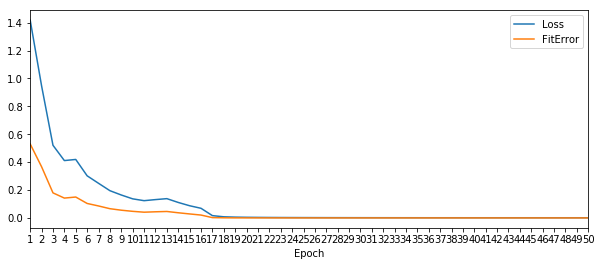

In [25]:
model_R50.plot_training_history(fig_size=(10,4))


## Score the Test Data to Predict Image Classes

Use evaluate() to use model to score the model data in te_img.

The output includes tables that summarize model scoring parameters and the names of model output tables in CAS.

In [26]:
evaluate = model_R50.evaluate(data=te_img, gpu = Gpu(devices=[0]) )
evaluate

NOTE: Using 4ca0ee83fca8: 1 out of 1 available GPU devices.


[ScoreInfo]

                          Descr         Value
 0  Number of Observations Read          4749
 1  Number of Observations Used          4749
 2  Misclassification Error (%)      45.86229
 3                   Loss Error      2.431902

[OutputCasTables]

   casLib              Name  Rows  Columns  \
 0  Happy  Valid_Res_lyQ5rL  4749       18   
 
                                        casTable  
 0  CASTable('Valid_Res_lyQ5rL', caslib='Happy')  

+ Elapsed: 8.12s, user: 16.9s, sys: 1.89s, mem: 464mb

In [27]:
s.columninfo('Valid_Res_lyQ5rL')

,Column,Label,ID,Type,RawLength,FormattedLength,Format,NFL,NFD
0,_image_,,1,varbinary,27199,27199,,0,0
1,_label_,,2,varchar,10,10,,0,0
2,_filename_0,,3,varchar,19,19,,0,0
3,_id_,,4,int64,8,12,,0,0
4,P__label_Age_1_5,Predicted: _label_=Age_1_5,5,double,8,12,BEST,12,0
5,P__label_Age_12_17,Predicted: _label_=Age_12_17,6,double,8,12,BEST,12,0
6,P__label_Age_18_20,Predicted: _label_=Age_18_20,7,double,8,12,BEST,12,0
7,P__label_Age_21_24,Predicted: _label_=Age_21_24,8,double,8,12,BEST,12,0
8,P__label_Age_25_34,Predicted: _label_=Age_25_34,9,double,8,12,BEST,12,0
9,P__label_Age_35_44,Predicted: _label_=Age_35_44,10,double,8,12,BEST,12,0


## View Scored Image Examples

Let's look at a few example images from the scored data, and see how the model evaluated the classification. Images are selected by random and the class value for the classification img_type attribute. The img_type attribute values are C, M, or A.

Scored images that are img_type='C' are correctly classified images. Scored images that are img_type='M' are misclassified images. The img_type='A' class returns all scored images, whether correctly classified or misclassifed.

The following code uses plot_evaluate_res() to view two correctly classified images selected at random from scored model data:

NOTE: Cloud Analytic Services dropped table TEMP_PLOT from caslib Happy.


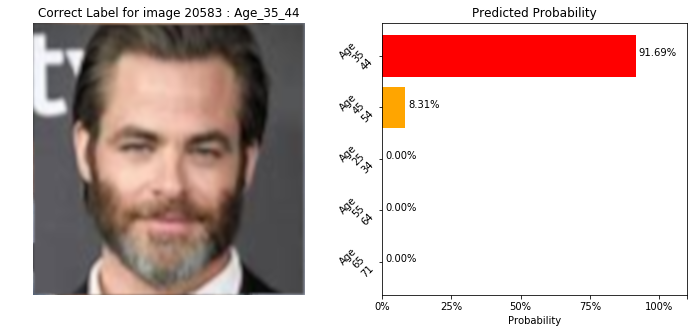

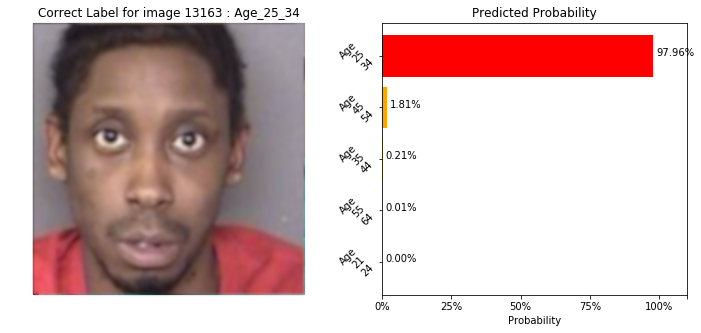

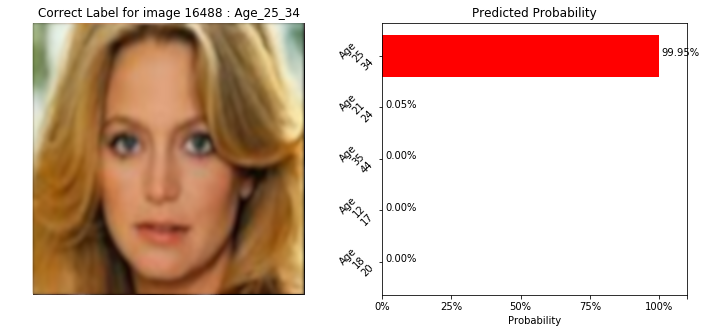

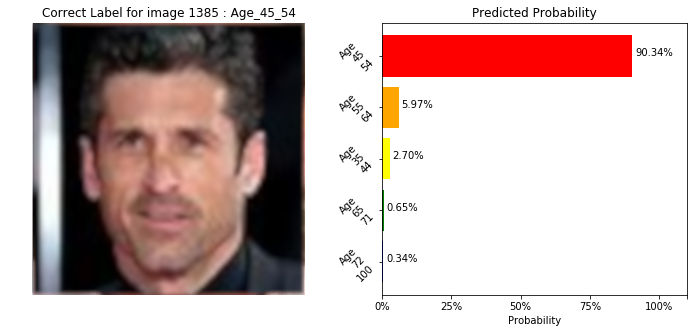

In [30]:
model_R50.plot_evaluate_res(img_type='C',randomize=True,n_images=4)

NOTE: Cloud Analytic Services dropped table TEMP_PLOT from caslib Happy.


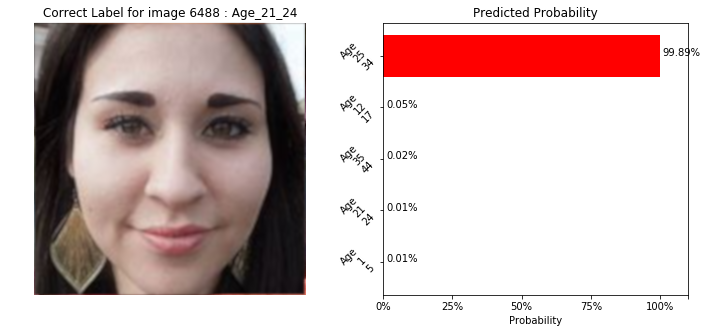

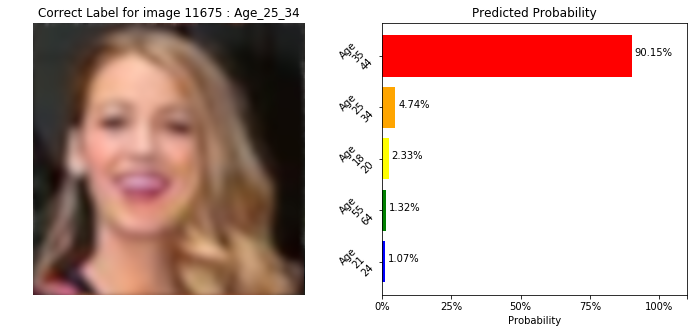

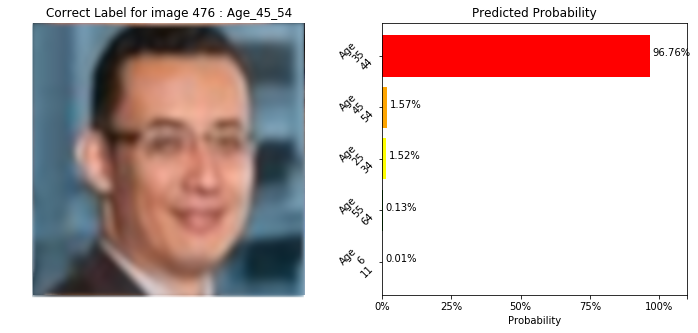

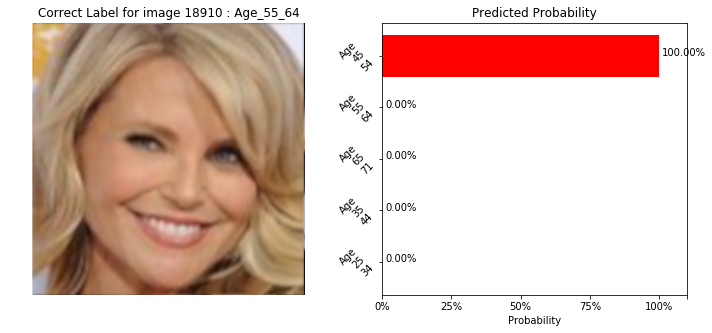

In [31]:
model_R50.plot_evaluate_res(img_type='M',randomize=True,n_images=4)

Running prediction ...
... finished running prediction
NOTE: The number of images in the table is too large, only 8 randomly selected images are used in analysis.
NOTE: Table SAMPLE_TBL_ERSCGO contains compressed images.


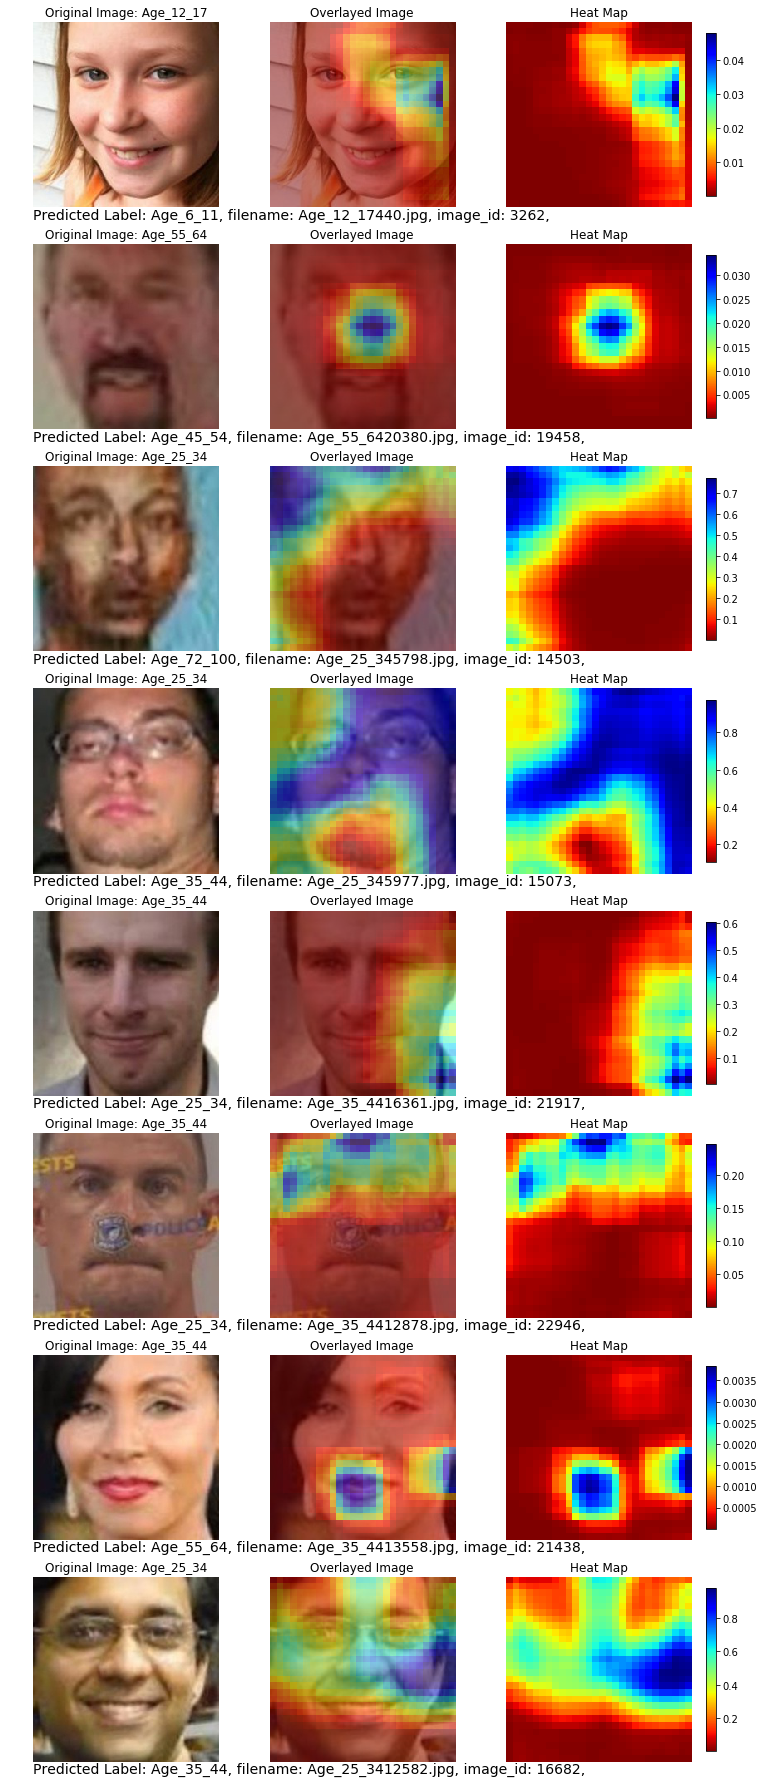

NOTE: Cloud Analytic Services dropped table SAMPLE_TBL_ErsCGO from caslib Happy.


In [34]:
misclass = model_R50.heat_map_analysis(data=te_img, mask_width=56, mask_height=56, step_size=8, img_type='M', max_display=2)

## Save Model as ASTORE for Deployment

The following code saves the model in ASTORE format which can then be used by SAS ESP to score live streaming event. 

In [33]:
model_R50.deploy(path=modelPath, output_format='astore')

NOTE: Model astore file saved successfully.


In [32]:
# Save Model Weights
s.save(model_R50.model_weights,
          name='model_R50_age_weights_v1.sashdat',
          saveAttrs=True,
          replace=True);

NOTE: Cloud Analytic Services saved the file model_R50_age_weights_v1.sashdat with attributes in caslib Happy.


In [20]:
s.endsession()

+ Elapsed: 0.000252s, user: 0.000129s, sys: 0.000102s, mem: 0.195mb